# DIGITAL EPIDEMIOLOGY

## Homework 1

### Martino Ciaperoni, Eleonora Grassucci, Tommaso Lanciano

## Abstract

Qualche parolina del cazzo!

In this study, we have reproduced the results obtained in [1], focusing our attention on the data provided by __Influnet__, the flu surveillance program run by the Italian Health Protection Agency.

The dataset has a weekly granularity, and reports the flu incidence for a time period spanning from 2015 to 2018. This information will be regarded as Ground Truth [__GT__].

The goal of this work, is to predict the ground truth, based only on Wikipedia's users habits. In fact, according to [1], the click rate of pages regarding flu, is highly correlated to the number of ILI (Influenza Like Illness) cases. Thus, we gathered our data from the Italian version of Wikipedia, and understood whether this phenomenon it's happening also in Italy.

#### Libraries

In order to reproduce the code in your machine, please be sure that you can import all the following packages.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import urllib
import requests
from bs4 import BeautifulSoup
import re
import networkx as nx
from tqdm import tqdm
from selenium import webdriver
import time
from functools import reduce
import glob
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from sklearn.linear_model import Lasso, Ridge,ElasticNet, BayesianRidge, Lars, LassoLars, LinearRegression, MultiTaskElasticNet, MultiTaskLasso, ridge_regression
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn import cross_validation
from itertools import combinations

C:\Users\tomma\AppData\Roaming\Python\Python36\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Structure of Folder

DESCRIZIONE DEI FOLDER

# Part 1

In this part, our focus is to collect data from the Italian Wikipedia for the "Influenza" page, and understanding if the click rate of this page, at weekly scale, is correlated to the GT.

### Influnet Data

As a first step, we want to check the trend of the flu incidence according to Influnet data.

For this purpose, data released by Influnet via .pdf files, were processed with Tabula and saved in an accessible format as a .csv file.

Once obtained these files, we loaded them in Python.

In [2]:
import os
files = os.listdir("data/influnet")

In [3]:
def process_influnet(file):
    df = pd.read_csv("data/influnet/"+file)
    df = df.iloc[2:,[0,4]] #Takes only rows and columns of interest
    df.columns=["Week","Incidence"] #Gives meaningful names to columns
    df = df.replace(to_replace=",", value=".", regex=True) #Replaces commas with dots
    df["Incidence"] = pd.to_numeric(df["Incidence"])
    return df

In [4]:
gt = pd.concat(map(process_influnet, files), axis=0, ignore_index=True)

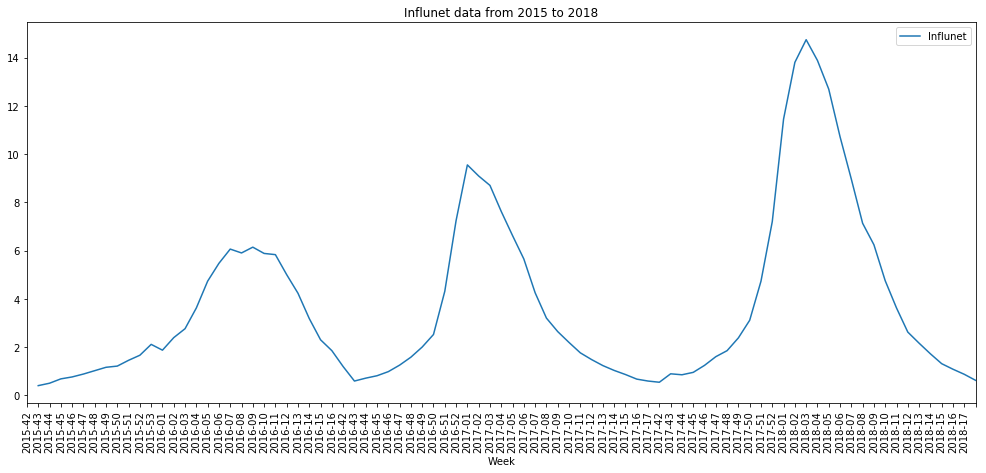

In [5]:
# Plot influnet data

gt.plot(x = "Week", y = "Incidence", label = "Influnet", figsize=(17,7))
plt.xticks(np.arange(-1, len(gt["Incidence"])), gt["Week"], rotation=90)
plt.title("Influnet data from 2015 to 2018")
plt.show()
plt.close()

### Wikipedia Data

In [6]:
#### FUNCTIONS ####

# Wiki_data Functions

def get_wiki_data(words):
    
    if len(words) > 10:
        return print("No man, you can put just 10 words maximum")

    bs_url = "https://tools.wmflabs.org/pageviews/?project=it.wikipedia.org&platform=all-access&agent=user&range=all-time&pages="+"|".join(words)

    driver = webdriver.Chrome()

    driver.get(bs_url)
    
    time.sleep(10)

    first_click = driver.find_elements_by_tag_name("button")
    first_click[6].click()
    
    driver.find_element_by_class_name("download-csv").click()

def get_week_number(entire_date):
    return entire_date.date().isocalendar()[1]

def get_year(entire_date):
    return entire_date.year

def merge_df(a,b):
    return a.append(b)


### Influnet Functions

def get_year_influnet(date):
    return int(date[:4])

def get_week_influnet(date):
    return int(date[5:])

def match_data(year,week):
    val = gt["Incidence"].loc[(gt["Year"] == year) & (gt["Week"] == week)]
    return float(val)

First, let's collect the time series related to the Wikipedia clicks at "Influenza" page. This line of code download the data we are looking for.

In [7]:
get_wiki_data(["Influenza"])

If we take a look to the data we collected:

In [8]:
### Read the File
flu_data = pd.read_csv("data/flu_data.csv")
flu_data.head()

,Date,Influenza
0,2015-07-01,121.0
1,2015-07-02,94.0
2,2015-07-03,103.0
3,2015-07-04,76.0
4,2015-07-05,99.0


We can see that data are available at daily granularity. Thus, after we gather the data, we need to perform a small preprocessing, in order to get the same informations we have in the GT.

Thus, our preprocessing includes:

- Aggregating the observations according to their week number.
- Selecting weeks that only appears in Influnet data.

In [9]:
def aggregate_data(df):
    
    ### Aggregate at weekly level 

    # Convert date to datetime
    df["Date"] = pd.to_datetime(df["Date"], yearfirst=True)

    # Get week number and year
    df["Week"] = df["Date"].apply(get_week_number)
    df["Year"] = df["Date"].apply(get_year)

    ### Select only weeks of interest for our analysis

    # Group by week number and year
    df = df.groupby(["Year", "Week"]).sum()
    df = df.stack()

    weeks_of_interest = {2015: [[42,53]], 2016: [[1,16], [42,52]], 2017: [[1,17], [42,52]], 2018: [[1,17]]}

    # Merging Dataframes
    temp = []
    for k,v in weeks_of_interest.items():
        for elem in v:
            temp.append(df.loc[k,list(range(elem[0],elem[1]+1))])

    df = reduce(merge_df, temp).unstack()
    
    return df

In [10]:
flu_data = aggregate_data(flu_data)

Taking a look again at data:

In [11]:
flu_data.head()

Influenza
Year Week           
2015 42       1400.0
     43       1317.0
     44       1226.0
     45       1336.0
     46       1298.0

We are sure that they have the same structure of the GT, thus we can start our comparison.

### Plotting data

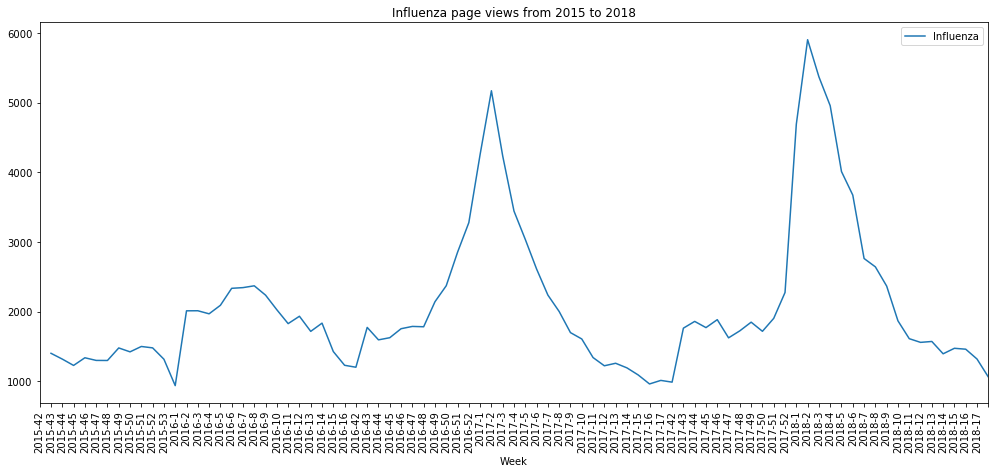

In [12]:
### Plot
flu_data.plot(y = "Influenza", label = "Influenza", figsize=(17,7))
plt.xticks(np.arange(-1, len(flu_data["Influenza"])), [str(x[0]) + "-" + str(x[1]) for x in flu_data.index], rotation=90)
plt.title("Influenza page views from 2015 to 2018")
plt.xlabel("Week")
plt.show()

### Part 2

Parte sul Grafo

In [13]:
# Download data 
get_wiki_data(["Vomito" , "Bronchite", "Faringite", "Rinite", "Paracetamolo","Tosse", "Raffreddore", "Febbre", "Ibuprofene", "Flurbiprofene"]) 
# Download data 
get_wiki_data(["Antipiretico", "Polmonite", "Tonsillite", "Pagina_principale", "Influenza"]) 

In [14]:
related_word_1 = pd.read_csv("data/related_word_data1.csv")
related_word_2 = pd.read_csv("data/related_word_data2.csv")

In [15]:
data = pd.concat(map(aggregate_data, [related_word_1,related_word_2]), axis = 1)

In [16]:
# Aggiunge GT ai data

gt["Year"] = gt["Week"].apply(get_year_influnet)
gt["Week"] = gt["Week"].apply(get_week_influnet)
data["GT"] = ["0" for _ in range(flu_data.shape[0])]
data = data.stack()
for year in data.index.levels[0]:
    for week in data.index.levels[1]:
        try:
            data.loc[year,[week],"GT"] = match_data(year,week)
        except:
            pass
data = data.unstack()

In [17]:
data

Bronchite Faringite Febbre Flurbiprofene Ibuprofene Paracetamolo  \
Year Week                                                                    
2015 42        2342      1895   3330           434       3828         6318   
     43        2442      1772   3307           409       3991         6241   
     44        2537      1661   3150           533       3863         5937   
     45        2415      1487   3305           563       3865         6064   
     46        2444      1471   3088           459       3911         5805   
     47        2220      1454   3284           589       3756         6042   
     48        2349      1455   3503           632       3724         6086   
     49        2398      1732   3471           579       3834         6715   
     50        2717      1770   3729           465       3776         6598   
     51        2644      1717   3701           583       3713         6583   
     52        2614      1633   3255           607       3533         6394   
     53        2049      1264   2669           504       2532         4945   
2016 1         4071      2285   5079           810       4489         8189   
     2         3450      2117   4654           669       4805         7621   
     3         3527      1921   4965           590       4496         7516   
     4         3792      2107   5849           538       4869         7953   
     5         3856      2240   6436           711       4988         8255   
     6         3761      2410   6675           611       4816         9518   
     7         3254      2425   6902           542       4880         8233   
     8         3284      2439   6958           496       4733         8638   
     9         3259      2592   6270           468       4716         7704   
     10        2773      2441   6122           505       4567         7756   
     11        2578      2587   5967           508       4597         7639   
     12        2590      2301   5690           418       4262         6987   
     13        2607      2104   5159           467       4322         6581   
     14        2380      2387   4268           446       4145         6830   
     15        2151      2235   3839           366       3957         5922   
     16        1942      2239   3364           413       4225         5735   
     42        2917      1916   3466           324       4197         7415   
     43        2613      1661   3200           317       4135         6942   
...             ...       ...    ...           ...        ...          ...   
2017 16        1626      1157   3030           219       4512         6045   
     17        1574      1138   2716           205       4177         5658   
     42        2202      1113   2782           347       3010         7025   
     43        2099      1137   4019           269       2998         6442   
     44        2232      1155   2885           337       3187         6972   
     45        2305      1474   2841           378       3154         6677   
     46        2524      1333   3139           366       3207         6805   
     47        2622      1826   3418           359       3183         7104   
     48        2832      1694   2940           379       3144         7103   
     49        3043      1704   2837           381       3179         7024   
     50        3687      1873   3176           398       3441         8267   
     51        3335      1764   3284           461       3526         8434   
     52        4704      2532   6488           675       5615        13867   
2018 1         4788      2458   5962           691       5159        12524   
     2         4152      2195   5287           597       6682        10066   
     3         3140      2058   4643           483       4440         9089   
     4         2976      2134   4810           519       4464         8368   
     5         2919      2165   4259           482       4223         7740   
     6         2601      2377   

CORRELATION E PLOT